# Análisis Exploratorio de Audio (EDA)

## Propósito
Este notebook realiza un **Análisis Exploratorio de Datos (EDA)** de archivos de audio del dataset ESC-50. El objetivo es entender cómo convertir audio en **espectrogramas Mel** que pueden ser usados como entrada para modelos de deep learning.

## Pipeline de Procesamiento

```
Audio (.wav)
     │
     ▼
┌─────────────────────┐
│   librosa.load()    │  → audio (array), Fs (sample rate)
└─────────────────────┘
     │
     ▼
┌─────────────────────┐
│  melspectrogram()   │  → Espectrograma (potencia)
└─────────────────────┘
     │
     ▼
┌─────────────────────┐
│   power_to_db()     │  → Espectrograma (dB)
└─────────────────────┘
     │
     ▼
┌─────────────────────┐
│    normalize()      │  → Espectrograma [-1, 1]
└─────────────────────┘
     │
     ▼
  Imagen lista para CNN
```

---
## 1. Importación de Librerías

- **librosa**: Librería principal para análisis y procesamiento de audio
- **matplotlib**: Para visualizaciones gráficas
- **utils**: Módulo local que contiene la función `Audio2Spectrogram` para encapsular el pipeline de conversión

In [3]:
import librosa
import matplotlib.pyplot as plt
from utils import *

---
## 2. Carga y Visualización de la Forma de Onda

### ¿Qué hacemos aquí?
1. Cargamos un archivo de audio del dataset ESC-50 (en este caso, clase 36 = "vacuum_cleaner")
2. `librosa.load()` retorna:
   - **audio**: Array numpy con las muestras de amplitud del audio
   - **Fs**: Sample rate (frecuencia de muestreo, típicamente 22050 Hz)
3. Visualizamos la **forma de onda** que muestra la variación de amplitud en el tiempo

### ¿Qué es la forma de onda?
La forma de onda representa la presión sonora (amplitud) a lo largo del tiempo. Es la representación más básica del audio pero no revela información sobre las frecuencias presentes.

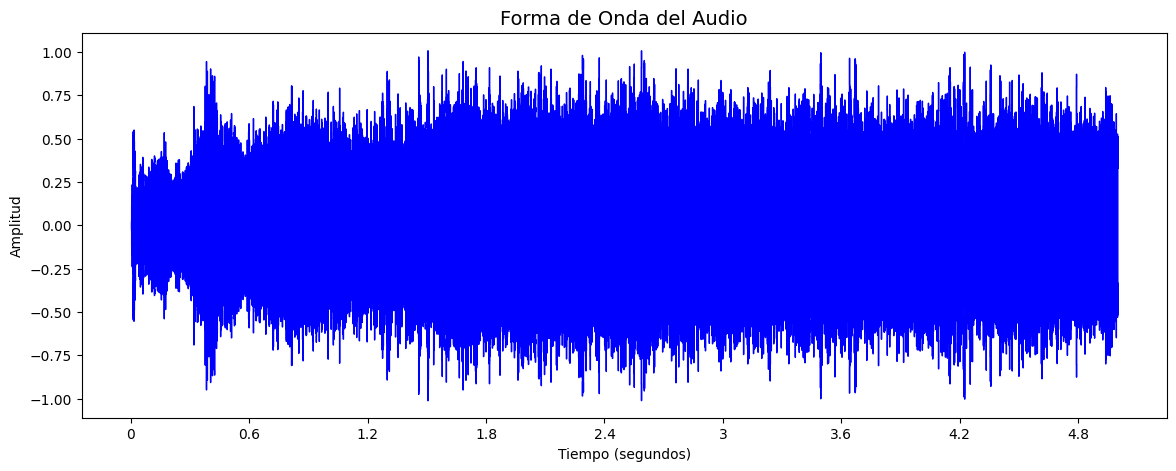

Duración del audio: 5.00 segundos
Sample rate: 22050 Hz
Número de muestras: 110,250


In [4]:
# Ruta al archivo de audio del dataset ESC-50
# El archivo 1-100210-A-36.wav corresponde a la clase 36 (vacuum_cleaner)
AUDIO_FILE = "data/ESC-50-master/audio/1-100210-A-36.wav"

# Cargar el audio
# - audio: array numpy con las muestras de audio
# - Fs: sample rate (frecuencia de muestreo en Hz)
audio, Fs = librosa.load(AUDIO_FILE)

# Crear figura para visualizar la forma de onda
fig, ax = plt.subplots(figsize=(14,5))

# Mostrar la forma de onda (amplitud vs tiempo)
librosa.display.waveshow(audio, sr=Fs, ax=ax, color="blue")
ax.set_title('Forma de Onda del Audio', fontsize=14)
ax.set_xlabel('Tiempo (segundos)')
ax.set_ylabel('Amplitud')
plt.show()

print(f"Duración del audio: {len(audio)/Fs:.2f} segundos")
print(f"Sample rate: {Fs} Hz")
print(f"Número de muestras: {len(audio):,}")

---
## 3. Creación del Mel-Espectrograma

### ¿Qué es un Mel-Espectrograma?
Un **espectrograma Mel** es una representación visual del audio que muestra:
- **Eje X**: Tiempo
- **Eje Y**: Frecuencia en escala Mel (imita la percepción humana)
- **Color**: Intensidad/Energía en cada frecuencia y tiempo

### Hiperparámetros del Espectrograma

| Parámetro | Descripción | Efecto |
|-----------|-------------|--------|
| `n_mels` | Número de bandas de frecuencia Mel | Más = mayor resolución frecuencial |
| `hop_length` | Muestras entre frames consecutivos | Menor = mayor resolución temporal |
| `win_length` | Tamaño de la ventana de análisis | Afecta el balance tiempo/frecuencia |
| `n_fft` | Tamaño de la FFT (potencia de 2) | Mayor = mejor resolución frecuencial |
| `fmax` | Frecuencia máxima a considerar | 20000 Hz ≈ límite audición humana |

### Proceso:
1. **melspectrogram()**: Calcula el espectrograma Mel (valores de potencia)
2. **power_to_db()**: Convierte a escala de decibelios (más interpretable)

C:\Users\XaviLara\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\feature\spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


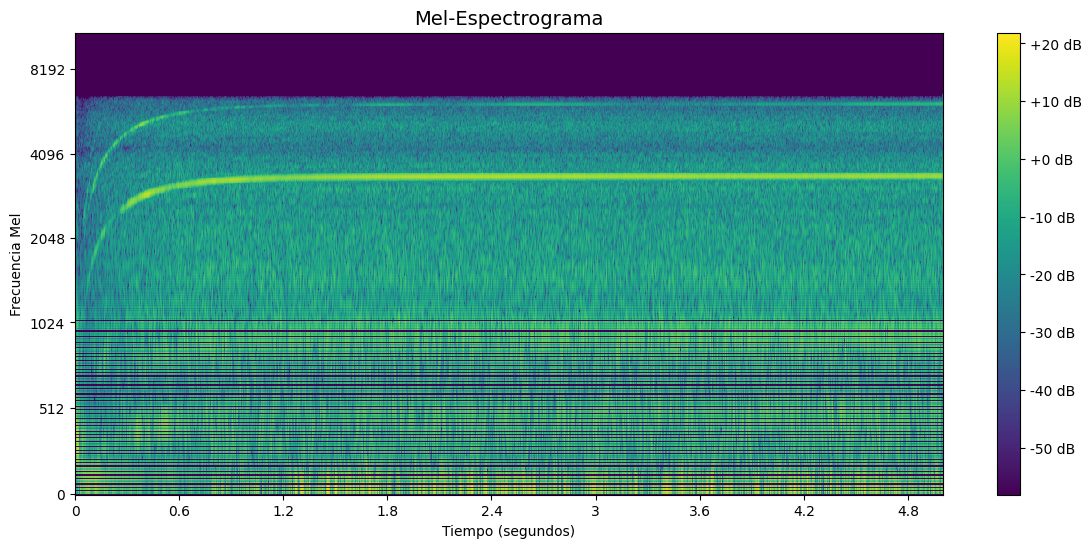

In [5]:
# ============================================================
# HIPERPARÁMETROS DEL MEL-ESPECTROGRAMA
# ============================================================

sample_rate = Fs

# n_mels: Número de bandas de frecuencia Mel
# - Determina la altura (resolución frecuencial) del espectrograma
# - Más bandas = más detalle en frecuencias
n_mels = 500

# hop_length: Número de muestras entre frames consecutivos
# - Determina la resolución temporal (ancho del espectrograma)
# - Menor valor = más frames = mejor resolución temporal
hop_length = 100

# win_length: Tamaño de la ventana de análisis en muestras
# - Debe ser menor o igual que n_fft
# - Ventana más grande = mejor resolución frecuencial pero peor temporal
win_length = 200

# n_fft: Tamaño de la ventana FFT
# - Siempre potencia de 2 para eficiencia
# - Mayor = mejor resolución frecuencial
n_fft = 1024

# fmax: Frecuencia máxima a considerar (en Hz)
# - El oído humano percibe hasta ~20000 Hz
fmax = 20000

# ============================================================
# CÁLCULO DEL MEL-ESPECTROGRAMA
# ============================================================

# Paso 1: Calcular el espectrograma Mel (valores de potencia)
spectrogram = librosa.feature.melspectrogram(
    y=audio,              # Señal de audio
    sr=sample_rate,       # Sample rate
    n_mels=n_mels,        # Bandas Mel
    hop_length=hop_length,# Salto entre frames
    win_length=win_length,# Tamaño de ventana
    n_fft=n_fft,          # Tamaño FFT
    fmax=fmax             # Frecuencia máxima
)

# Paso 2: Convertir potencia a decibelios (dB)
# Los valores en dB son más interpretables y tienen mejor rango dinámico
spectrogram = librosa.power_to_db(spectrogram)

# Visualizar el espectrograma
plt.figure(figsize=(14, 6))
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length,
                         x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Espectrograma', fontsize=14)
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Frecuencia Mel')
plt.show()

---
## 4. Inspección del Espectrograma

### Interpretación de los valores:
- Los valores están en **escala de decibelios (dB)**
- **Valores bajos** (ej: -58 dB) = silencio o muy poca energía en esa frecuencia
- **Valores altos** (ej: +10 dB) = alta energía en esa frecuencia y tiempo

### Dimensiones:
- **Shape (500, 1103)** significa:
  - 500 bandas de frecuencia Mel (eje vertical)
  - 1103 frames temporales (eje horizontal)

In [6]:
# Mostrar las dimensiones del espectrograma
print("="*50)
print("DIMENSIONES DEL ESPECTROGRAMA")
print("="*50)
print(f"Shape: {spectrogram.shape}")
print(f"  - {spectrogram.shape[0]} bandas de frecuencia Mel (altura)")
print(f"  - {spectrogram.shape[1]} frames temporales (ancho)")

print("\n" + "="*50)
print("ESTADÍSTICAS DE VALORES (en dB)")
print("="*50)
print(f"Valor mínimo: {spectrogram.min():.2f} dB")
print(f"Valor máximo: {spectrogram.max():.2f} dB")
print(f"Valor medio:  {spectrogram.mean():.2f} dB")

print("\n" + "="*50)
print("MUESTRA DE VALORES")
print("="*50)
print(spectrogram)

DIMENSIONES DEL ESPECTROGRAMA
Shape: (500, 1103)
  - 500 bandas de frecuencia Mel (altura)
  - 1103 frames temporales (ancho)

ESTADÍSTICAS DE VALORES (en dB)
Valor mínimo: -58.15 dB
Valor máximo: 21.85 dB
Valor medio:  -24.06 dB

MUESTRA DE VALORES
[[-58.148872  -58.148872  -58.148872  ... -58.148872  -58.148872
  -58.148872 ]
 [ -8.181315  -16.34145    -8.770206  ...  -6.6161113   5.2107744
    2.8409219]
 [ -3.1099558 -11.270092   -3.6988475 ...  -1.5447524  10.282134
    7.9122806]
 ...
 [-58.148872  -58.148872  -58.148872  ... -58.148872  -58.148872
  -58.148872 ]
 [-58.148872  -58.148872  -58.148872  ... -58.148872  -58.148872
  -58.148872 ]
 [-58.148872  -58.148872  -58.148872  ... -58.148872  -58.148872
  -58.148872 ]]


---
## 5. Uso de la Función Utilitaria Audio2Spectrogram

### ¿Qué hace la función `Audio2Spectrogram`?
Esta función del archivo `utils.py` encapsula todo el pipeline de conversión:

```python
def Audio2Spectrogram(audio_file, dict_cfg):
    audio, Fs = librosa.load(audio_file)           # 1. Cargar audio
    spectrogram = librosa.feature.melspectrogram(  # 2. Calcular Mel-espectrograma
        y=audio, sr=Fs, **dict_cfg
    )
    spectrogram = librosa.power_to_db(spectrogram) # 3. Convertir a dB
    return librosa.util.normalize(spectrogram)     # 4. Normalizar a [-1, 1]
```

### Diferencia clave con el método manual:
La función **normaliza** el espectrograma al rango **[-1, 1]**, lo cual es muy importante para el entrenamiento de redes neuronales ya que:
- Acelera la convergencia del modelo
- Evita problemas de gradientes explosivos/desvanecientes
- Estandariza la entrada para diferentes audios

Configuración utilizada:
  n_mels: 500
  hop_length: 100
  win_length: 500
  n_fft: 1024
  fmax: 22000


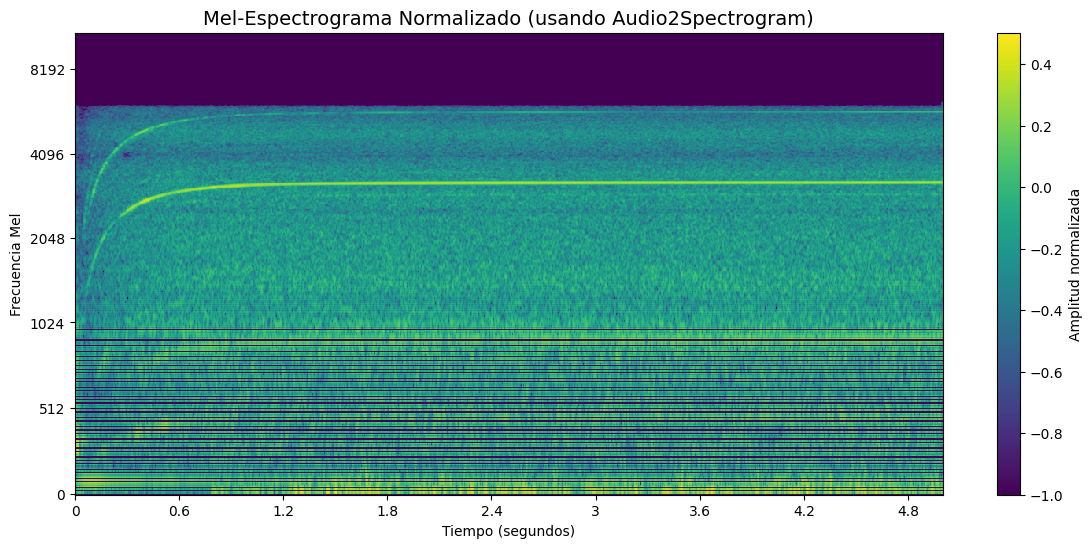


Shape del espectrograma: (500, 1103)
Rango de valores: [-1.0000, 0.5030]

✅ Valores normalizados en rango [-1, 1] - Listo para CNN!


In [7]:
# ============================================================
# CONFIGURACIÓN DE PARÁMETROS (usando diccionario)
# ============================================================

audio_cfg = dict(
    n_mels = 500,        # Bandas de frecuencia Mel
    hop_length = 100,    # Salto entre frames
    win_length = 500,    # Tamaño de ventana (diferente al anterior)
    n_fft = 1024,        # Tamaño FFT
    fmax = 22000         # Frecuencia máxima (22 kHz)
)

print("Configuración utilizada:")
for key, value in audio_cfg.items():
    print(f"  {key}: {value}")

# ============================================================
# USAR LA FUNCIÓN UTILITARIA
# ============================================================

# Audio2Spectrogram hace todo el pipeline y además NORMALIZA
spec = Audio2Spectrogram(AUDIO_FILE, audio_cfg)

# Visualizar
plt.figure(figsize=(14, 6))
librosa.display.specshow(spec, sr=Fs, hop_length=audio_cfg['hop_length'],
                         x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(label='Amplitud normalizada')
plt.title('Mel-Espectrograma Normalizado (usando Audio2Spectrogram)', fontsize=14)
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Frecuencia Mel')
plt.show()

# Mostrar información
print(f"\nShape del espectrograma: {spec.shape}")
print(f"Rango de valores: [{spec.min():.4f}, {spec.max():.4f}]")
print("\n✅ Valores normalizados en rango [-1, 1] - Listo para CNN!")

---
## 6. Conclusiones del EDA

### Resumen de hallazgos:

1. **Audio de 5 segundos** → Espectrograma de aproximadamente 1100 frames temporales

2. **500 bandas Mel** proporcionan alta resolución frecuencial, capturando detalles importantes del audio

3. **La normalización es crucial** para el entrenamiento de redes neuronales:
   - Sin normalizar: valores en rango [-58, +10] dB
   - Normalizado: valores en rango [-1, 1]

4. **Los hiperparámetros afectan la representación**:
   - `hop_length` menor = más resolución temporal pero espectrograma más ancho
   - `n_mels` mayor = más resolución frecuencial pero más costoso computacionalmente

### Siguiente paso:
Usar estos espectrogramas como "imágenes" de entrada para una red convolucional (CNN) como ResNet-50 para clasificar los 50 tipos de sonidos del dataset ESC-50.

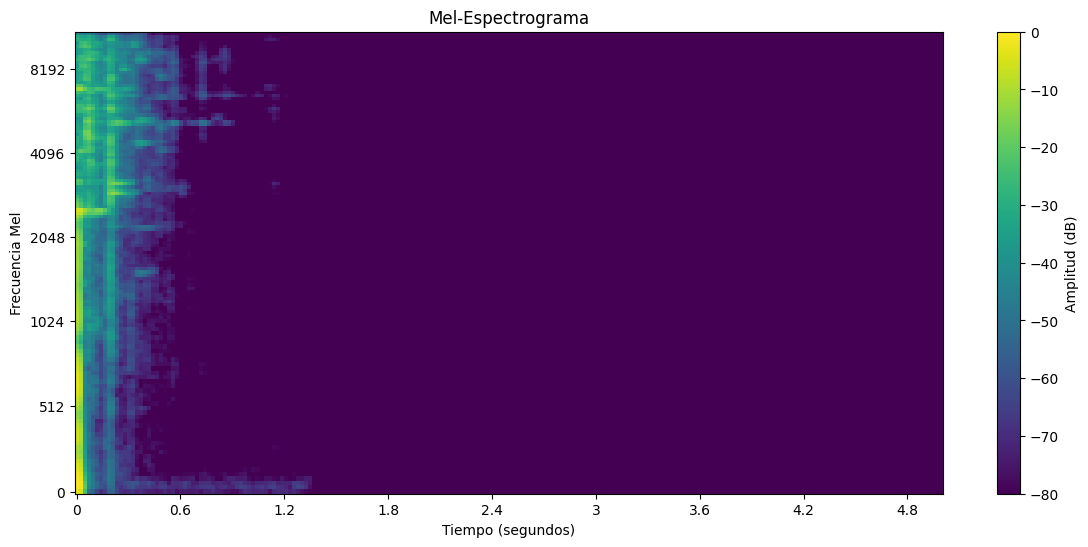

Shape: (128, 216)
Rango de valores: [-80.0000, 0.0000]


In [8]:
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
# Cargar el espectrograma guardado
spectrogram = np.load("data/ESC-50-master/audio_image/1-977-A-39.npy")
# Visualizarlo
plt.figure(figsize=(14, 6))
librosa.display.specshow(spectrogram, 
                         x_axis='time', 
                         y_axis='mel', 
                         cmap='viridis')
plt.colorbar(label='Amplitud (dB)')
plt.title('Mel-Espectrograma')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Frecuencia Mel')
plt.show()
# Ver información
print(f"Shape: {spectrogram.shape}")
print(f"Rango de valores: [{spectrogram.min():.4f}, {spectrogram.max():.4f}]")